# Download Data Set

Grab the json data set from GitHub. There are two data sets available.

1. Spire Logs data set (970 000 samples)
1. Jorbs data set (5700 samples)

### Cached Data

During development the pre-processed data is saved in the vm. Enable the `cached_data` flag to use the cached data. This will fail if the the json data has not been pre-processed in the current vm or if the cached data is not manually uploaded

In [5]:
import json

result = []
for fname in os.listdir('./out/1671181569'):
    f = os.path.join('./out/1671181569', fname)
    
    with open(f, 'r') as infile:
        result.extend(json.load(infile))
with open('./out/1671181569/new_data.json', 'w') as out_file:
    json.dump(result, out_file)

In [6]:
import urllib.request
import json
import gzip
import numpy as np

# Set to False to use the (very small) Jorbs data set
dataset = 'official'  # 'spire', 'jorbs', or 'official'
cached_data = False

if cached_data:
    loaded_data = np.load('cached_comp_data.npz')
    X = loaded_data['X']
    Y = loaded_data['Y']
elif dataset == 'official':
    # Official dataset (~970 000 samples)
    data_url = './out/1671181569/new_data.json'

    with open(data_url, "r") as url:
        json_data = json.loads(url.read())
elif dataset == 'spire':
# Spire Logs (~970 000 samples)
    data_url = 'https://raw.githubusercontent.com/alexdriedger/SlayTheSpireFightPredictor/a8dd8d41193218179d52b2001953652d850fb2bd/out/gz/Spire%20Logs-2%20(970%2C000).gz'

    with urllib.request.urlopen(data_url) as url:
        gz_file = gzip.GzipFile(fileobj=url, mode='r')
        json_data = json.load(gz_file)
else:
    # Jorbs data (~5700 samples)
    data_url = 'https://raw.githubusercontent.com/alexdriedger/SlayTheSpireFightPredictor/34196cfd19b469a4a4404cd21c68760cc823770d/out/1597656440/Jorbs%20(5700).json'
    with urllib.request.urlopen(data_url) as url:
        json_data = json.loads(url.read().decode())

if cached_data is False:
    print(f'Data has {len(json_data)} samples.')


Data has 6314074 samples.


# Pre-Process Data

Load the json training examples and process them into vectors that can be used in a neural network

In [7]:
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import LabelEncoder
import re
import tensorflow as tf
import uuid

The json data is created from `.run` files processed in a separate python script. The json data is a list of objects with the following structure:

```
{
    "cards": [
        "Strike_R",
        "Strike_R",
        "Strike_R",
        "Strike_R",
        "Defend_R",
        "Defend_R",
        "Defend_R",
        "Defend_R",
        "Strike_R",
        "Bash",
        "AscendersBane",
        "Clothesline",
        "Iron Wave",
        "Armaments",
        "Combust",
        "True Grit"
    ],
    "relics": [
        "Burning Blood"
    ],
    "max_hp": 82,
    "entering_hp": 82,
    "character": "IRONCLAD",
    "ascension": 20,
    "enemies": "Lots of Slimes",
    "potion_used": false,
    "floor": 5,
    "damage_taken": 14
}
```

In [8]:
# Categories for one hot encoder. Categories are in alphabetical order and is the order used by OneHotEncoder
ALL_CARDS = ['A Thousand Cuts', 'A Thousand Cuts+1', 'Accuracy', 'Accuracy+1', 'Acrobatics', 'Acrobatics+1', 'Adaptation', 'Adaptation+1', 'Adrenaline', 'Adrenaline+1', 'After Image', 'After Image+1', 'Aggregate', 'Aggregate+1', 'All For One', 'All For One+1', 'All Out Attack', 'All Out Attack+1', 'Alpha', 'Alpha+1', 'Amplify', 'Amplify+1', 'Anger', 'Anger+1', 'Apotheosis', 'Apotheosis+1', 'Armaments', 'Armaments+1', 'AscendersBane', 'Auto Shields', 'Auto Shields+1', 'Backflip', 'Backflip+1', 'Backstab', 'Backstab+1', 'Ball Lightning', 'Ball Lightning+1', 'Bandage Up', 'Bandage Up+1', 'Bane', 'Bane+1', 'Barrage', 'Barrage+1', 'Barricade', 'Barricade+1', 'Bash', 'Bash+1', 'Battle Trance', 'Battle Trance+1', 'BattleHymn', 'BattleHymn+1', 'Beam Cell', 'Beam Cell+1', 'BecomeAlmighty', 'BecomeAlmighty+1', 'Berserk', 'Berserk+1', 'Beta', 'Beta+1', 'Biased Cognition', 'Biased Cognition+1', 'Bite', 'Bite+1', 'Blade Dance', 'Blade Dance+1', 'Blasphemy', 'Blasphemy+1', 'Blind', 'Blind+1', 'Blizzard', 'Blizzard+1', 'Blood for Blood', 'Blood for Blood+1', 'Bloodletting', 'Bloodletting+1', 'Bludgeon', 'Bludgeon+1', 'Blur', 'Blur+1', 'Body Slam', 'Body Slam+1', 'BootSequence', 'BootSequence+1', 'Bouncing Flask', 'Bouncing Flask+1', 'BowlingBash', 'BowlingBash+1', 'Brilliance', 'Brilliance+1', 'Brutality', 'Brutality+1', 'Buffer', 'Buffer+1', 'Bullet Time', 'Bullet Time+1', 'Burn', 'Burn+1', 'Burning Pact', 'Burning Pact+1', 'Burst', 'Burst+1', 'Calculated Gamble', 'Calculated Gamble+1', 'Caltrops', 'Caltrops+1', 'Capacitor', 'Capacitor+1', 'Carnage', 'Carnage+1', 'CarveReality', 'CarveReality+1', 'Catalyst', 'Catalyst+1', 'Chaos', 'Chaos+1', 'Chill', 'Chill+1', 'Choke', 'Choke+1', 'Chrysalis', 'Chrysalis+1', 'Clash', 'Clash+1', 'ClearTheMind', 'ClearTheMind+1', 'Cleave', 'Cleave+1', 'Cloak And Dagger', 'Cloak And Dagger+1', 'Clothesline', 'Clothesline+1', 'Clumsy', 'Cold Snap', 'Cold Snap+1', 'Collect', 'Collect+1', 'Combust', 'Combust+1', 'Compile Driver', 'Compile Driver+1', 'Concentrate', 'Concentrate+1', 'Conclude', 'Conclude+1', 'ConjureBlade', 'ConjureBlade+1', 'Consecrate', 'Consecrate+1', 'Conserve Battery', 'Conserve Battery+1', 'Consume', 'Consume+1', 'Coolheaded', 'Coolheaded+1', 'Core Surge', 'Core Surge+1', 'Corpse Explosion', 'Corpse Explosion+1', 'Corruption', 'Corruption+1', 'Creative AI', 'Creative AI+1', 'Crescendo', 'Crescendo+1', 'Crippling Poison', 'Crippling Poison+1', 'CrushJoints', 'CrushJoints+1', 'CurseOfTheBell', 'CutThroughFate', 'CutThroughFate+1', 'Dagger Spray', 'Dagger Spray+1', 'Dagger Throw', 'Dagger Throw+1', 'Dark Embrace', 'Dark Embrace+1', 'Dark Shackles', 'Dark Shackles+1', 'Darkness', 'Darkness+1', 'Dash', 'Dash+1', 'Dazed', 'Dazed+1', 'Deadly Poison', 'Deadly Poison+1', 'Decay', 'DeceiveReality', 'DeceiveReality+1', 'Deep Breath', 'Deep Breath+1', 'Defend', 'Defend+1', 'Deflect', 'Deflect+1', 'Defragment', 'Defragment+1', 'Demon Form', 'Demon Form+1', 'DeusExMachina', 'DeusExMachina+1', 'DevaForm', 'DevaForm+1', 'Devotion', 'Devotion+1', 'Die Die Die', 'Die Die Die+1', 'Disarm', 'Disarm+1', 'Discovery', 'Discovery+1', 'Distraction', 'Distraction+1', 'Dodge and Roll', 'Dodge and Roll+1', 'Doom and Gloom', 'Doom and Gloom+1', 'Doppelganger', 'Doppelganger+1', 'Double Energy', 'Double Energy+1', 'Double Tap', 'Double Tap+1', 'Doubt', 'Dramatic Entrance', 'Dramatic Entrance+1', 'Dropkick', 'Dropkick+1', 'Dual Wield', 'Dual Wield+1', 'Dualcast', 'Dualcast+1', 'Echo Form', 'Echo Form+1', 'Electrodynamics', 'Electrodynamics+1', 'EmptyBody', 'EmptyBody+1', 'EmptyFist', 'EmptyFist+1', 'EmptyMind', 'EmptyMind+1', 'Endless Agony', 'Endless Agony+1', 'Enlightenment', 'Enlightenment+1', 'Entrench', 'Entrench+1', 'Envenom', 'Envenom+1', 'Eruption', 'Eruption+1', 'Escape Plan', 'Escape Plan+1', 'Establishment', 'Establishment+1', 'Evaluate', 'Evaluate+1', 'Eviscerate', 'Eviscerate+1', 'Evolve', 'Evolve+1', 'Exhume', 'Exhume+1', 'Expertise', 'Expertise+1', 'Expunger', 'Expunger+1', 'FTL', 'FTL+1', 'FameAndFortune', 'FameAndFortune+1', 'Fasting2', 'Fasting2+1', 'FearNoEvil', 'FearNoEvil+1', 'Feed', 'Feed+1', 'Feel No Pain', 'Feel No Pain+1', 'Fiend Fire', 'Fiend Fire+1', 'Finesse', 'Finesse+1', 'Finisher', 'Finisher+1', 'Fire Breathing', 'Fire Breathing+1', 'Fission', 'Fission+1', 'Flame Barrier', 'Flame Barrier+1', 'Flash of Steel', 'Flash of Steel+1', 'Flechettes', 'Flechettes+1', 'Flex', 'Flex+1', 'FlurryOfBlows', 'FlurryOfBlows+1', 'Flying Knee', 'Flying Knee+1', 'FlyingSleeves', 'FlyingSleeves+1', 'FollowUp', 'FollowUp+1', 'Footwork', 'Footwork+1', 'Force Field', 'Force Field+1', 'ForeignInfluence', 'ForeignInfluence+1', 'Forethought', 'Forethought+1', 'Fusion', 'Fusion+1', 'Gash', 'Gash+1', 'Genetic Algorithm', 'Genetic Algorithm+1', 'Ghostly', 'Ghostly Armor', 'Ghostly Armor+1', 'Ghostly+1', 'Glacier', 'Glacier+1', 'Glass Knife', 'Glass Knife+1', 'Go for the Eyes', 'Go for the Eyes+1', 'Good Instincts', 'Good Instincts+1', 'Grand Finale', 'Grand Finale+1', 'Halt', 'Halt+1', 'HandOfGreed', 'HandOfGreed+1', 'Havoc', 'Havoc+1', 'Headbutt', 'Headbutt+1', 'Heatsinks', 'Heatsinks+1', 'Heavy Blade', 'Heavy Blade+1', 'Heel Hook', 'Heel Hook+1', 'Hello World', 'Hello World+1', 'Hemokinesis', 'Hemokinesis+1', 'Hologram', 'Hologram+1', 'Hyperbeam', 'Hyperbeam+1', 'Immolate', 'Immolate+1', 'Impatience', 'Impatience+1', 'Impervious', 'Impervious+1', 'Indignation', 'Indignation+1', 'Infernal Blade', 'Infernal Blade+1', 'Infinite Blades', 'Infinite Blades+1', 'Inflame', 'Inflame+1', 'Injury', 'InnerPeace', 'InnerPeace+1', 'Insight', 'Insight+1', 'Intimidate', 'Intimidate+1', 'Iron Wave', 'Iron Wave+1', 'J.A.X.', 'J.A.X.+1', 'Jack Of All Trades', 'Jack Of All Trades+1', 'Judgement', 'Judgement+1', 'Juggernaut', 'Juggernaut+1', 'JustLucky', 'JustLucky+1', 'Leap', 'Leap+1', 'Leg Sweep', 'Leg Sweep+1', 'LessonLearned', 'LessonLearned+1', 'LikeWater', 'LikeWater+1', 'Limit Break', 'Limit Break+1', 'LiveForever', 'LiveForever+1', 'Lockon', 'Lockon+1', 'Loop', 'Loop+1', 'Machine Learning', 'Machine Learning+1', 'Madness', 'Madness+1', 'Magnetism', 'Magnetism+1', 'Malaise', 'Malaise+1', 'Master of Strategy', 'Master of Strategy+1', 'MasterReality', 'MasterReality+1', 'Masterful Stab', 'Masterful Stab+1', 'Mayhem', 'Mayhem+1', 'Meditate', 'Meditate+1', 'Melter', 'Melter+1', 'MentalFortress', 'MentalFortress+1', 'Metallicize', 'Metallicize+1', 'Metamorphosis', 'Metamorphosis+1', 'Meteor Strike', 'Meteor Strike+1', 'Mind Blast', 'Mind Blast+1', 'Miracle', 'Miracle+1', 'Multi-Cast', 'Multi-Cast+1', 'Necronomicurse', 'Neutralize', 'Neutralize+1', 'Night Terror', 'Night Terror+1', 'Nirvana', 'Nirvana+1', 'Normality', 'Noxious Fumes', 'Noxious Fumes+1', 'Offering', 'Offering+1', 'Omega', 'Omega+1', 'Omniscience', 'Omniscience+1', 'Outmaneuver', 'Outmaneuver+1', 'Pain', 'Panacea', 'Panacea+1', 'Panache', 'Panache+1', 'PanicButton', 'PanicButton+1', 'Parasite', 'PathToVictory', 'PathToVictory+1', 'Perfected Strike', 'Perfected Strike+1', 'Perseverance', 'Perseverance+1', 'Phantasmal Killer', 'Phantasmal Killer+1', 'PiercingWail', 'PiercingWail+1', 'Poisoned Stab', 'Poisoned Stab+1', 'Pommel Strike', 'Pommel Strike+1', 'Power Through', 'Power Through+1', 'Pray', 'Pray+1', 'Predator', 'Predator+1', 'Prepared', 'Prepared+1', 'Pride', 'Prostrate', 'Prostrate+1', 'Protect', 'Protect+1', 'Pummel', 'Pummel+1', 'Purity', 'Purity+1', 'Quick Slash', 'Quick Slash+1', 'Rage', 'Rage+1', 'Ragnarok', 'Ragnarok+1', 'Rainbow', 'Rainbow+1', 'Rampage', 'Rampage+1', 'ReachHeaven', 'ReachHeaven+1', 'Reaper', 'Reaper+1', 'Reboot', 'Reboot+1', 'Rebound', 'Rebound+1', 'Reckless Charge', 'Reckless Charge+1', 'Recycle', 'Recycle+1', 'Redo', 'Redo+1', 'Reflex', 'Reflex+1', 'Regret', 'Reinforced Body', 'Reinforced Body+1', 'Reprogram', 'Reprogram+1', 'Riddle With Holes', 'Riddle With Holes+1', 'Rip and Tear', 'Rip and Tear+1', 'RitualDagger', 'RitualDagger+1', 'Rupture', 'Rupture+1', 'Sadistic Nature', 'Sadistic Nature+1', 'Safety', 'Safety+1', 'Sanctity', 'Sanctity+1', 'SandsOfTime', 'SandsOfTime+1', 'SashWhip', 'SashWhip+1', 'Scrape', 'Scrape+1', 'Scrawl', 'Scrawl+1', 'Searing Blow', 'Searing Blow+1', 'Second Wind', 'Second Wind+1', 'Secret Technique', 'Secret Technique+1', 'Secret Weapon', 'Secret Weapon+1', 'Seeing Red', 'Seeing Red+1', 'Seek', 'Seek+1', 'Self Repair', 'Self Repair+1', 'Sentinel', 'Sentinel+1', 'Setup', 'Setup+1', 'Sever Soul', 'Sever Soul+1', 'Shame', 'Shiv', 'Shiv+1', 'Shockwave', 'Shockwave+1', 'Shrug It Off', 'Shrug It Off+1', 'SignatureMove', 'SignatureMove+1', 'Skewer', 'Skewer+1', 'Skim', 'Skim+1', 'Slice', 'Slice+1', 'Slimed', 'Slimed+1', 'Smite', 'Smite+1', 'SpiritShield', 'SpiritShield+1', 'Spot Weakness', 'Spot Weakness+1', 'Stack', 'Stack+1', 'Static Discharge', 'Static Discharge+1', 'Steam', 'Steam Power', 'Steam Power+1', 'Steam+1', 'Storm', 'Storm of Steel', 'Storm of Steel+1', 'Storm+1', 'Streamline', 'Streamline+1', 'Strike', 'Strike+1', 'Study', 'Study+1', 'Sucker Punch', 'Sucker Punch+1', 'Sunder', 'Sunder+1', 'Survivor', 'Survivor+1', 'Sweeping Beam', 'Sweeping Beam+1', 'Swift Strike', 'Swift Strike+1', 'Swivel', 'Swivel+1', 'Sword Boomerang', 'Sword Boomerang+1', 'Tactician', 'Tactician+1', 'TalkToTheHand', 'TalkToTheHand+1', 'Tantrum', 'Tantrum+1', 'Tempest', 'Tempest+1', 'Terror', 'Terror+1', 'The Bomb', 'The Bomb+1', 'Thinking Ahead', 'Thinking Ahead+1', 'ThirdEye', 'ThirdEye+1', 'ThroughViolence', 'ThroughViolence+1', 'Thunder Strike', 'Thunder Strike+1', 'Thunderclap', 'Thunderclap+1', 'Tools of the Trade', 'Tools of the Trade+1', 'Transmutation', 'Transmutation+1', 'Trip', 'Trip+1', 'True Grit', 'True Grit+1', 'Turbo', 'Turbo+1', 'Twin Strike', 'Twin Strike+1', 'Underhanded Strike', 'Underhanded Strike+1', 'Undo', 'Undo+1', 'Unload', 'Unload+1', 'Uppercut', 'Uppercut+1', 'Vault', 'Vault+1', 'Vengeance', 'Vengeance+1', 'Venomology', 'Venomology+1', 'Vigilance', 'Vigilance+1', 'Violence', 'Violence+1', 'Void', 'Void+1', 'Wallop', 'Wallop+1', 'Warcry', 'Warcry+1', 'WaveOfTheHand', 'WaveOfTheHand+1',
             'Weave', 'Weave+1', 'Well Laid Plans', 'Well Laid Plans+1', 'WheelKick', 'WheelKick+1', 'Whirlwind', 'Whirlwind+1', 'White Noise', 'White Noise+1', 'Wild Strike', 'Wild Strike+1', 'WindmillStrike', 'WindmillStrike+1', 'Wireheading', 'Wireheading+1', 'Wish', 'Wish+1', 'Worship', 'Worship+1', 'Wound', 'Wound+1', 'Wraith Form v2', 'Wraith Form v2+1', 'WreathOfFlame', 'WreathOfFlame+1', 'Writhe', 'Zap', 'Zap+1']
ALL_RELICS = ['Akabeko', 'Anchor', 'Ancient Tea Set', 'Art of War', 'Astrolabe', 'Bag of Marbles', 'Bag of Preparation', 'Bird Faced Urn', 'Black Blood', 'Black Star', 'Blood Vial', 'Bloody Idol', 'Blue Candle', 'Boot', 'Bottled Flame', 'Bottled Lightning', 'Bottled Tornado', 'Brimstone', 'Bronze Scales', 'Burning Blood', 'Busted Crown', 'Cables', 'Calipers', 'Calling Bell', 'CaptainsWheel', 'Cauldron', 'Centennial Puzzle', 'CeramicFish', 'Champion Belt', "Charon's Ashes", 'Chemical X', 'CloakClasp', 'ClockworkSouvenir', 'Coffee Dripper', 'Cracked Core', 'CultistMask', 'Cursed Key', 'Damaru', 'Darkstone Periapt', 'DataDisk', 'Dead Branch', 'Dodecahedron', 'DollysMirror', 'Dream Catcher', 'Du-Vu Doll', 'Ectoplasm', 'Emotion Chip', 'Empty Cage', 'Enchiridion', 'Eternal Feather', 'FaceOfCleric', 'FossilizedHelix', 'Frozen Egg 2', 'Frozen Eye', 'FrozenCore', 'Fusion Hammer', 'Gambling Chip', 'Ginger', 'Girya', 'Golden Idol', 'GoldenEye', 'Gremlin Horn', 'GremlinMask', 'HandDrill', 'Happy Flower', 'HolyWater', 'HornCleat', 'HoveringKite', 'Ice Cream', 'Incense Burner', 'InkBottle', 'Inserter', 'Juzu Bracelet', 'Kunai', 'Lantern', "Lee's Waffle", 'Letter Opener', 'Lizard Tail', 'Magic Flower', 'Mango', 'Mark of Pain', 'Mark of the Bloom', 'Matryoshka', 'MawBank', 'MealTicket', 'Meat on the Bone', 'Medical Kit', 'Melange', 'Membership Card', 'Mercury Hourglass', 'Molten Egg 2', 'Mummified Hand', 'MutagenicStrength', 'Necronomicon', 'NeowsBlessing', "Nilry's Codex", 'Ninja Scroll', "Nloth's Gift", 'NlothsMask', 'Nuclear Battery', 'Nunchaku', 'Odd Mushroom', 'Oddly Smooth Stone', 'Old Coin', 'Omamori', 'OrangePellets', 'Orichalcum', 'Ornamental Fan', 'Orrery', "Pandora's Box", 'Pantograph', 'Paper Crane', 'Paper Frog', 'Peace Pipe', 'Pear', 'Pen Nib', "Philosopher's Stone", 'Pocketwatch', 'Potion Belt', 'Prayer Wheel', 'PreservedInsect', 'PrismaticShard', 'PureWater', 'Question Card', 'Red Mask', 'Red Skull', 'Regal Pillow', 'Ring of the Serpent', 'Ring of the Snake', 'Runic Capacitor', 'Runic Cube', 'Runic Dome', 'Runic Pyramid', 'SacredBark', 'Self Forming Clay', 'Shovel', 'Shuriken', 'Singing Bowl', 'SlaversCollar', 'Sling', 'Smiling Mask', 'Snake Skull', 'Snecko Eye', 'Sozu', 'Spirit Poop', 'SsserpentHead', 'StoneCalendar', 'Strange Spoon', 'Strawberry', 'StrikeDummy', 'Sundial', 'Symbiotic Virus', 'TeardropLocket', 'The Courier', 'The Specimen', 'TheAbacus', 'Thread and Needle', 'Tingsha', 'Tiny Chest', 'Tiny House', 'Toolbox', 'Torii', 'Tough Bandages', 'Toxic Egg 2', 'Toy Ornithopter', 'TungstenRod', 'Turnip', 'TwistedFunnel', 'Unceasing Top', 'Vajra', 'Velvet Choker', 'VioletLotus', 'War Paint', 'WarpedTongs', 'Whetstone', 'White Beast Statue', 'WingedGreaves', 'WristBlade', 'Yang']
ALL_ENCOUNTERS = ['2 Fungi Beasts', '2 Louse', '2 Orb Walkers', '2 Thieves', '3 Byrds', '3 Cultists', '3 Darklings', '3 Louse', '3 Sentries', '3 Shapes', '4 Byrds', '4 Shapes', 'Apologetic Slime', 'Automaton', 'Awakened One', 'Blue Slaver', 'Book of Stabbing', 'Centurion and Healer', 'Champ', 'Chosen', 'Chosen and Byrds', 'Collector', 'Colosseum Nobs', 'Colosseum Slavers', 'Cultist', 'Cultist and Chosen', 'Donu and Deca', 'Exordium Thugs', 'Exordium Wildlife', 'Flame Bruiser 1 Orb', 'Flame Bruiser 2 Orb', 'Giant Head', 'Gremlin Gang', 'Gremlin Leader', 'Gremlin Nob', 'Hexaghost', 'Jaw Worm', 'Jaw Worm Horde', 'Lagavulin', 'Lagavulin Event', 'Large Slime', 'Looter', 'Lots of Slimes', 'Masked Bandits', 'Maw', 'Mind Bloom Boss Battle', 'Mysterious Sphere', 'Nemesis', 'Orb Walker', 'Red Slaver', 'Reptomancer', 'Sentry and Sphere', 'Shell Parasite', 'Shelled Parasite and Fungi', 'Shield and Spear', 'Slaver and Parasite', 'Slavers', 'Slime Boss', 'Small Slimes', 'Snake Plant', 'Snecko', 'Snecko and Mystics', 'Snecko and Mystics', 'Sphere and 2 Shapes', 'Spheric Guardian', 'Spire Growth', 'The Eyes', 'The Guardian', 'The Heart', 'The Mushroom Lair', 'Time Eater', 'Transient', 'Writhing Mass']
ALL_CHARACTERS = ['DEFECT', 'IRONCLAD', 'THE_SILENT', 'WATCHER']

## Pre-Process with Loops

Iterate through each training example and turn each field in the json data into each part of the vector needed for training.

This will later be optomized into vectorized code.

In [9]:
def encode_list(list_to_encode, category):
  np_array = np.array(list_to_encode)
  encoder = OneHotEncoder(categories=[category], sparse=False)
  n_by_1 = np_array.reshape(len(np_array), 1)
  onehot_encoded = encoder.fit_transform(n_by_1)
  summed = np.sum(onehot_encoded, axis=0, dtype=np.float16)
  return summed

def encode_single(value, category):
  np_array = np.array([[value]])
  encoder = OneHotEncoder(categories=[category], sparse=False)
  onehot_encoded = encoder.fit_transform(np_array)
  collapsed = np.sum(onehot_encoded, axis=0, dtype=np.float16)
  # inverse = encoder.inverse_transform(collapsed[np.newaxis, ...])
  # print(np.array_equal(np_array, inverse))
  return collapsed

In [10]:
def generalize_strikes_and_defends(cards):
  """
  Modifies any character specific Strikes and Defends (eg. Strike_R) into
  general Strikes and Defends(Strike)
  """
  for i, s in enumerate(cards):
    if s.startswith('Strike_') or s.startswith('Defend_'):
      cards[i] = re.sub('_.', '', s)
  return cards

def encode_cards(cards):
  """
  Encodes a list of cards into a modified one-hot vector where each index
  represents how many of that card are in the deck. The vector has length of
  ALL_CARDS.
  """
  cards = np.array(cards)
  generalize_strikes_and_defends(cards)
  return encode_list(cards, ALL_CARDS)

In [11]:
def encode_relics(relics):
  """
  Encodes a list of relics into a modified one-hot vector of length ALL_RELICS.
  If the relic is present in relics, it will be represented as 1 in the returned
  vector
  """
  relics = np.array(relics)
  return encode_list(relics, ALL_RELICS)

In [12]:
def encode_encounter(encounter):
  """
  Encode an encounter into a one-hot vector of length ALL_ENCOUNTERS
  """
  return encode_single(encounter, ALL_ENCOUNTERS)

In [13]:
def encode_character(character):
  """
  Encode the chosen character into a one-hot vector of length ALL_CHARACTERS
  """
  return encode_single(character, ALL_CHARACTERS)

In [14]:
def encode_sample_with_loop(sample):
  """
  Encode a single sample into a 1D vector
  """
  cards = encode_cards(sample['cards'])
  relics = encode_relics(sample['relics'])
  encounter = encode_encounter(sample['enemies'])
  num_and_bool_data = np.array([sample['max_hp'], sample['entering_hp'], sample['ascension'], int(sample['potion_used'] == 'true')], dtype=np.float16)
  return np.concatenate((cards, relics, encounter, num_and_bool_data))

In [15]:
# Less than 10 samples of 50 000 affected by limits
NUM_CARDS_FOR_EMB = 45
NUM_RELICS_FOR_EMB = 25
card_encoder = LabelEncoder()
card_encoder.fit(ALL_CARDS)
relic_encoder = LabelEncoder()
relic_encoder.fit(ALL_RELICS)
encounter_encoder = LabelEncoder()
encounter_encoder.fit(ALL_ENCOUNTERS)

def encode_sample_embedding_with_loop(sample):
  """
  Encode a single sample into a 1D vector. Uses a label encoder for cards, relics, and encounters.
  To be used with the model with embedding layers
  """
  # Zap = 714 after the +1
  cards = np.array(sample['cards'])
  generalize_strikes_and_defends(cards)
  enc_cards = card_encoder.transform(cards)
  enc_cards += 1
  enc_cards = enc_cards.reshape(1, -1)
  enc_cards = tf.keras.preprocessing.sequence.pad_sequences(enc_cards, maxlen=NUM_CARDS_FOR_EMB, padding='post', truncating='post')

  relics = np.array(sample['relics'])
  enc_relics = relic_encoder.transform(relics)
  enc_relics += 1
  enc_relics = enc_relics.reshape(1, -1)
  enc_relics = tf.keras.preprocessing.sequence.pad_sequences(enc_relics, maxlen=NUM_RELICS_FOR_EMB, padding='post', truncating='post')

  encounter = np.array(sample['enemies'])
  enc_encounter = encounter_encoder.transform([encounter])
  enc_encounter = enc_encounter.reshape(1, -1)

  num_and_bool_data = np.array([sample['max_hp'], sample['entering_hp'], sample['ascension'], int(sample['potion_used'] == 'true')], ndmin=2)

  return np.concatenate((enc_cards, enc_relics, enc_encounter, num_and_bool_data), axis=None)

In [48]:
# Set to True to test embedding experiments
USE_EMBEDDING = True

def preprocess_with_loop(data, log=True, log_freq=1000, cache=True, cache_freq=100000):
  """
  Pre-processes the data one sample at a time using loops.
  X has shape: (num_samples, training_vec_len)
  Y has shape: (num_samples)
  """
  processed_samples = []
  y = []
  cached_files = []
  cache_file_prefix = 'cached_preprocess_data-'
  cache_file_extension = '.npz'

  if log:
    print(f'Processing {len(data)} samples')
  
  for i, sample in enumerate(data):
    if cache and i % cache_freq == 0 and i != 0:
      cache_file_name = cache_file_prefix + str(uuid.uuid4()) + cache_file_extension
      print(f'Caching files into ' + cache_file_name)
      cached_files.append(cache_file_name)

      X = np.vstack(processed_samples)
      Y = np.array(y, dtype='float16')
      np.savez_compressed(cache_file_name, X=X, Y=Y)
      processed_samples.clear()
      y.clear()

    if log and i % log_freq == 0 and i != 0:
      print(f'{((i / len(data)) * 100):.1f} % complete. => {i} of {len(data)}')

    if USE_EMBEDDING:
      processed_samples.append(encode_sample_embedding_with_loop(sample))
    else:
      # print(encode_sample_embedding_with_loop(sample).dtype)
      processed_samples.append(encode_sample_with_loop(sample))
    
    y.append(sample['damage_taken'])
  
  if not cache or not cached_files:
    X = np.vstack(processed_samples)
    Y = np.array(y, dtype='float16')
    np.savez_compressed('cached_comp_data.npz', X=X, Y=Y)
    return X, Y
  else:
    loaded_files_x = []
    loaded_files_y = []
    for f in cached_files:
      loaded_data = np.load(f)
      loaded_files_x.append(loaded_data['X'])
      loaded_files_y.append(loaded_data['Y'])
    if processed_samples:
      loaded_files_x.append(np.vstack(processed_samples)) 
      loaded_files_y.append(np.array(y, dtype='float16')) 
    X = np.concatenate(loaded_files_x)
    Y = np.concatenate(loaded_files_y)
    np.savez_compressed('cached_comp_data.npz', X=X, Y=Y)
  return X, Y

In [30]:
def test_cache():
  trunc = json_data[:10]
  x_no_cache, y_no_cache = preprocess_with_loop(trunc, cache=False)
  x_cache, y_cache = preprocess_with_loop(trunc, cache_freq=3)
  
  print(y_no_cache.dtype)
  print(y_cache.dtype)
  print(x_no_cache.dtype)
  print(x_cache.dtype)
  print(np.array_equal(x_no_cache, x_cache))
  print(np.array_equal(y_no_cache, y_cache))
# test_cache()

## Pre-Process Vectorized

In [31]:
def generalize_single_strike_or_defend(card_name):
  if s.startswith('Strike_') or s.startswith('Defend_'):
    return re.sub('_.', '', s)
  return card_name

In [32]:
from tensorflow import keras
from keras.layers import Input, Dense, Dropout, Concatenate, Average, Embedding, Lambda
from keras.layers import concatenate
from keras.models import Model, Sequential
from sklearn.preprocessing import MaxAbsScaler
from sklearn.model_selection import train_test_split
import datetime, os

%load_ext tensorboard

# !pip install -U keras-tuner
# import kerastuner as kt

The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [49]:
if cached_data is False:
    import warnings
    # run block of code and catch warnings
    with warnings.catch_warnings():
        # ignore all caught warnings
        warnings.filterwarnings("ignore")
        # execute code that will generate warnings
        print(f'Original data set size: {len(json_data)}')
        filtered_data = [x for x in json_data if x['ascension'] >= 15]
        print(f'Original data set size: {len(filtered_data)}')
        X, Y = preprocess_with_loop(filtered_data, log_freq=10000)

Original data set size: 6314074
Original data set size: 1423148
Processing 1423148 samples
0.7 % complete. => 10000 of 1423148
1.4 % complete. => 20000 of 1423148
2.1 % complete. => 30000 of 1423148
2.8 % complete. => 40000 of 1423148
3.5 % complete. => 50000 of 1423148
4.2 % complete. => 60000 of 1423148
4.9 % complete. => 70000 of 1423148
5.6 % complete. => 80000 of 1423148
6.3 % complete. => 90000 of 1423148
Caching files into cached_preprocess_data-6ab589b3-b457-47e3-93bd-436278a550d8.npz
7.0 % complete. => 100000 of 1423148
7.7 % complete. => 110000 of 1423148
8.4 % complete. => 120000 of 1423148
9.1 % complete. => 130000 of 1423148
9.8 % complete. => 140000 of 1423148
10.5 % complete. => 150000 of 1423148
11.2 % complete. => 160000 of 1423148
11.9 % complete. => 170000 of 1423148
12.6 % complete. => 180000 of 1423148
13.4 % complete. => 190000 of 1423148
Caching files into cached_preprocess_data-54cb1452-b85d-4458-9067-f9ae480429b6.npz
14.1 % complete. => 200000 of 1423148
14.8 %

In [21]:
def scale_X(X_data):
  """
  Used with one hot encoded model
  """
  X_copy = np.copy(X_data)
  max_abs_scaler = MaxAbsScaler()
  X_maxabs = max_abs_scaler.fit_transform(X_copy)
  with open('input_scales.json', 'w') as out_file:
    json.dump(max_abs_scaler.scale_.tolist(), out_file)
  return X_maxabs

In [22]:
def scale_Y(Y_data):
  Y_copy = np.copy(Y_data)

  # Scale Y
  Y_copy /= 100

  # To allow healing (negative damage), uncomment `Y[Y < -1] = -1` and comment out `Y[Y < 0] = 0`
  Y_copy[Y_copy < -1] = -1 # Healing (negative damage)
  # Y_copy[Y_copy < 0] = 0 # No healing

  # Cap damage taken at 100
  Y_copy[Y_copy > 1] = 1
  return Y_copy

## Build and Train the Model

We are using a Seqeuntial model with Dense and Dropout layers. Mean Absolute Error (MAE) is used as the loss function for two main reasons

1. MAE has a better validation loss than Mean Squared Error (MSE)
1. MAE represents the avg error on predictions. Example: "You will lose 7 HP +/- X HP in this fight" where X is the Mean Absolute Error

In [22]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(400, input_shape=(970,), activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(1)
])
 
model.summary()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=.001),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error', 'mean_squared_error'])
 
# Tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
 
X_scaled = scale_X(X)
Y_scaled = scale_Y(Y)
X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33, shuffle=True)
 
history = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_split=0.2, callbacks=[tensorboard_callback])

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 400)               388400    
                                                                 
 dropout_2 (Dropout)         (None, 400)               0         
                                                                 
 dense_4 (Dense)             (None, 40)                16040     
                                                                 
 dropout_3 (Dropout)         (None, 40)                0         
                                                                 
 dense_5 (Dense)             (None, 1)                 41        
                                                                 
Total params: 404,481
Trainable params: 404,481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
5846/5846 [==========================

In [23]:
test_scores = model.evaluate(X_test, Y_test, verbose=2)

print("Test loss:", test_scores[0])
print("Test accuracy:", test_scores[1])

3599/3599 - 5s - loss: 0.0687 - mean_absolute_error: 0.0687 - mean_squared_error: 0.0111 - 5s/epoch - 1ms/step
Test loss: 0.06866243481636047
Test accuracy: 0.06866243481636047


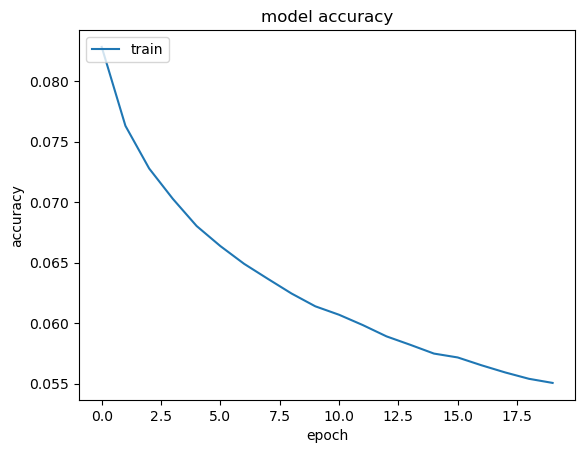

In [24]:
import matplotlib.pyplot as plt
plt.plot(history.history['mean_absolute_error'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

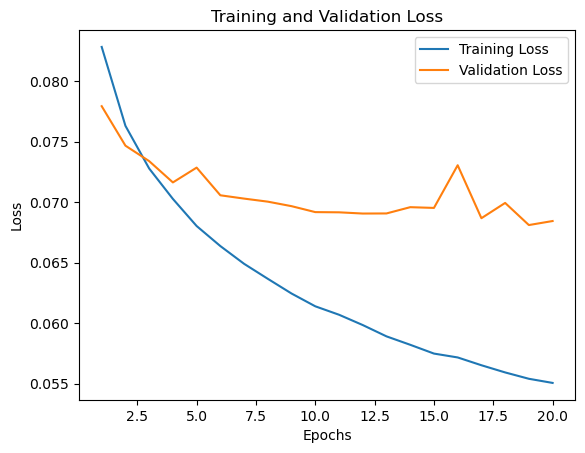

In [29]:
history_dict = history.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,label='Training Loss')
plt.plot(epochs, val_acc,label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [23]:
# Custom average function to ignore masked layers
def avg_labmda_fun(x, mask):
  mask_cast = keras.backend.cast(mask, 'float32')
  expanded = keras.backend.expand_dims(mask_cast)
  count = tf.keras.backend.sum(mask_cast)
  sum = keras.backend.sum(expanded * x, axis=1)
  return sum / count

In [24]:
def train_embedding_model(bs=32, dropout=0.1):
  # Embed cards and average output vectors
  card_input = Input(shape=(NUM_CARDS_FOR_EMB, ), name='cards_input')
  card_embedding = Embedding(len(ALL_CARDS) + 1, 26, mask_zero=True)(card_input)
  card_average = Lambda(avg_labmda_fun, output_shape=(26, ), mask=None)(card_embedding)

  # Embed relics and average output vectors
  relic_input = Input(shape=(NUM_RELICS_FOR_EMB, ), name='relics_input')
  relic_embedding = Embedding(len(ALL_RELICS) + 1, 13, mask_zero=True)(relic_input)
  relic_average = Lambda(avg_labmda_fun, output_shape=(13, ), mask=None)(relic_embedding)

  # Embed encounter. There is only a single encounter but the lambda is used to reshape the vector
  encounter_input = Input(shape=(1, ), name='encounter_input')
  encounter_embedding = Embedding(len(ALL_ENCOUNTERS), 8)(encounter_input)
  encounter_layer_reshape = Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(8, ))(encounter_embedding)

  numbers_input = Input(shape=(4, ), name='num_and_bool_input')

  # Concatenate before sending to Dense layers
  merged = concatenate([card_average, relic_average, encounter_layer_reshape, numbers_input])

  dense_0 = Dense(400, activation='relu')(merged)
  drop_out_0 = Dropout(.2)(dense_0)
  dense_1 = Dense(40, activation='relu')(drop_out_0)
  drop_out_1 = Dropout(dropout)(dense_1)
  dense_out = Dense(1)(drop_out_1)

  emb_model = Model(inputs=[card_input, relic_input, encounter_input, numbers_input], outputs=dense_out)
  emb_model.summary()

  emb_model.compile(
      optimizer=keras.optimizers.RMSprop(learning_rate=.0001),
      loss='mae',
      metrics=['mae', 'mse'])

  logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
  tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

  Y_scaled = scale_Y(Y)
  X_train, X_test, Y_train, Y_test = train_test_split(X, Y_scaled, test_size=0.33, shuffle=False)

  cards_col = X_train[:, 0:NUM_CARDS_FOR_EMB]
  relic_index = NUM_CARDS_FOR_EMB + NUM_RELICS_FOR_EMB
  relics_col = X_train[:, NUM_CARDS_FOR_EMB:relic_index]
  encounter_index = relic_index + 1
  encounter_col = X_train[:, relic_index:encounter_index]
  num_and_bool_col = X_train[:, encounter_index:]
  max_abs_scaler = MaxAbsScaler()
  num_and_bool_col = max_abs_scaler.fit_transform(num_and_bool_col)

  history = emb_model.fit(x={'cards_input': cards_col, 'relics_input': relics_col, 'encounter_input': encounter_col, 'num_and_bool_input': num_and_bool_col}, y=Y_train, batch_size=bs, epochs=20, validation_split=0.2)
  return emb_model, history

# if USE_EMBEDDING:
#   emb_model, emb_history = train_embedding_model()

In [25]:
def inspect_embeddings():
  embeddings = emb_model.layers[3].get_weights()[0]
  embeddings.shape
  weights = dict()
  for i, name in enumerate(ALL_CARDS):
    weights[name] = embeddings[i]
    # print(f'{name}:\t{embeddings[i]}')

  print(weights['Pommel Strike'])
  print(weights['Sucker Punch'])

if USE_EMBEDDING:
  inspect_embeddings()

NameError: name 'emb_model' is not defined

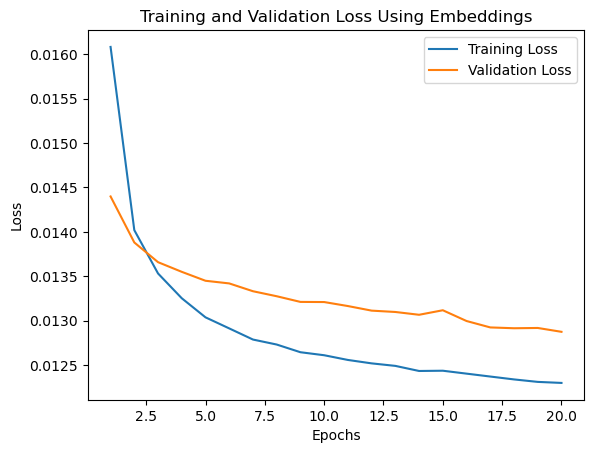

In [47]:
history_dict_emb = emb_history.history
train_acc_emb = history_dict_emb['loss']
val_acc_emb = history_dict_emb['val_loss']
epochs_emb = range(1, len(history_dict_emb['loss'])+1)
plt.plot(epochs_emb, train_acc_emb,label='Training Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss')
plt.title('Training and Validation Loss Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

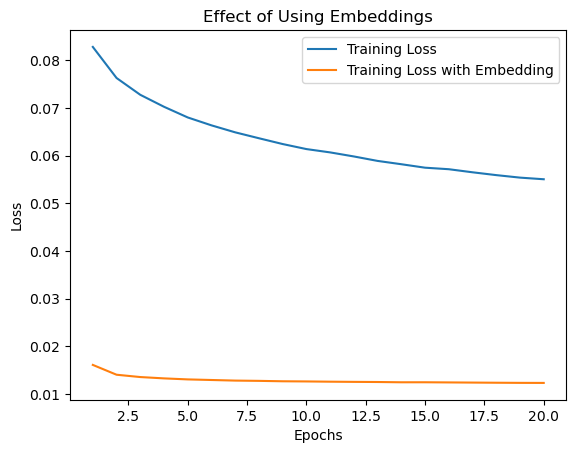

In [48]:
plt.plot(epochs, train_acc,label='Training Loss')
plt.plot(epochs_emb, train_acc_emb,label='Training Loss with Embedding')
plt.title('Effect of Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

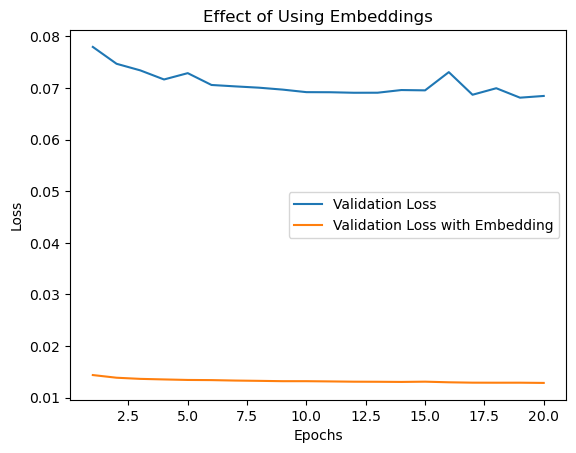

In [49]:
plt.plot(epochs, val_acc,label='Validation Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss with Embedding')
plt.title('Effect of Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [52]:
batch_sizes = [16, 32, 64, 128, 256, 512]

epochs_emb = range(1, 11)
train_accs_bs = []
val_accs_bs = []

for batch_size in batch_sizes:
    bs_model, bs_history = train_embedding_model(batch_size)
    train_accs_bs.append(bs_history.history['loss'])
    val_accs_bs.append(bs_history.history['val_loss'])

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_15 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                            

 dropout_10 (Dropout)           (None, 40)           0           ['dense_18[0][0]']               
                                                                                                  
 dense_19 (Dense)               (None, 1)            41          ['dropout_10[0][0]']             
                                                                                                  
Total params: 23,635
Trainable params: 23,635
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/10
5846/5846 [==============================] - 36s 6ms/step - loss: 0.0162 - mae: 0.0923 - val_loss: 0.0145 - val_mae: 0.0856
Epoch 2/10
5846/5846 [==============================] - 36s 6ms/step - loss: 0.0140 - mae: 0.0837 - val_loss: 0.0140 - val_mae: 0.0843
Epoch 3/10
5846/5846 [==============================] - 36s 6ms/step - loss: 0.0135 - mae: 0.0820 - val_loss: 0.0138 - val_mae: 0.0830
Epoch 4/10
5846/5846 [========

 embedding_25 (Embedding)       (None, 25, 13)       2340        ['relics_input[0][0]']           
                                                                                                  
 embedding_26 (Embedding)       (None, 1, 8)         584         ['encounter_input[0][0]']        
                                                                                                  
 lambda_24 (Lambda)             (None, 26)           0           ['embedding_24[0][0]']           
                                                                                                  
 lambda_25 (Lambda)             (None, 13)           0           ['embedding_25[0][0]']           
                                                                                                  
 lambda_26 (Lambda)             (None, 8)            0           ['embedding_26[0][0]']           
                                                                                                  
 num_and_b

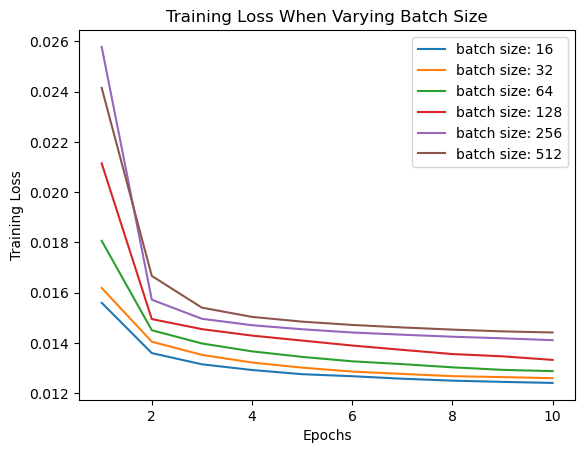

In [54]:
for i in range(len(batch_sizes)):
    plt.plot(range(1, 11), train_accs_bs[i],label='batch size: '+ str(batch_sizes[i]))
plt.title('Training Loss When Varying Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

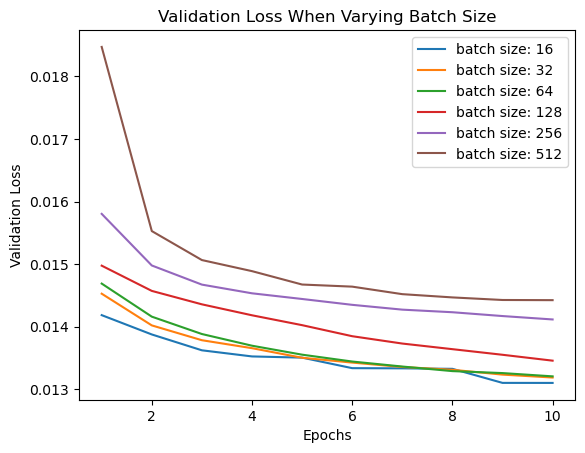

In [55]:
for i in range(len(batch_sizes)):
    plt.plot(range(1, 11), val_accs_bs[i],label='batch size: '+ str(batch_sizes[i]))
plt.title('Validation Loss When Varying Batch Size')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [84]:
def print_test_metrics(mod):
    # Embed cards and average output vectors
    card_input = Input(shape=(NUM_CARDS_FOR_EMB, ), name='cards_input')
    card_embedding = Embedding(len(ALL_CARDS) + 1, 26, mask_zero=True)(card_input)
    card_average = Lambda(avg_labmda_fun, output_shape=(26, ), mask=None)(card_embedding)

    # Embed relics and average output vectors
    relic_input = Input(shape=(NUM_RELICS_FOR_EMB, ), name='relics_input')
    relic_embedding = Embedding(len(ALL_RELICS) + 1, 13, mask_zero=True)(relic_input)
    relic_average = Lambda(avg_labmda_fun, output_shape=(13, ), mask=None)(relic_embedding)

    # Embed encounter. There is only a single encounter but the lambda is used to reshape the vector
    encounter_input = Input(shape=(1, ), name='encounter_input')
    encounter_embedding = Embedding(len(ALL_ENCOUNTERS), 8)(encounter_input)
    encounter_layer_reshape = Lambda(lambda x: keras.backend.mean(x, axis=1), output_shape=(8, ))(encounter_embedding)

    numbers_input = Input(shape=(4, ), name='num_and_bool_input')

    # Concatenate before sending to Dense layers
    merged = concatenate([card_average, relic_average, encounter_layer_reshape, numbers_input])

    dense_1 = Dense(40, activation='relu')(merged)
    drop_out_1 = Dropout(.1)(dense_1)
    dense_out = Dense(1)(drop_out_1)


    emb_model = Model(inputs=[card_input, relic_input, encounter_input, numbers_input], outputs=dense_out)
    emb_model.summary()

    emb_model.compile(
      optimizer=keras.optimizers.RMSprop(learning_rate=.0001),
      loss='mae',
      metrics=['mae', 'mse'])

    logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
    tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)

    Y_scaled = scale_Y(Y)
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y_scaled, test_size=0.33, shuffle=False)

    cards_col = X_test[:, 0:NUM_CARDS_FOR_EMB]
    relic_index = NUM_CARDS_FOR_EMB + NUM_RELICS_FOR_EMB
    relics_col = X_test[:, NUM_CARDS_FOR_EMB:relic_index]
    encounter_index = relic_index + 1
    encounter_col = X_test[:, relic_index:encounter_index]
    num_and_bool_col = X_test[:, encounter_index:]
    max_abs_scaler = MaxAbsScaler()
    num_and_bool_col = max_abs_scaler.fit_transform(num_and_bool_col)

    # history = emb_model.fit(x={'cards_input': cards_col, 'relics_input': relics_col, 'encounter_input': encounter_col, 'num_and_bool_input': num_and_bool_col}, y=Y_train, batch_size=bs, epochs=10, validation_split=0.2)


    embedding_test_scores = mod.evaluate({'cards_input': cards_col, 'relics_input': relics_col, 'encounter_input': encounter_col, 'num_and_bool_input': num_and_bool_col}, Y_test, verbose=2)

    print("Test loss:", embedding_test_scores[0])
    print("Test accuracy:", embedding_test_scores[1])

In [62]:
model_add_dropout, history_add_dropou = train_embedding_model(32)

Model: "model_10"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_39 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                           

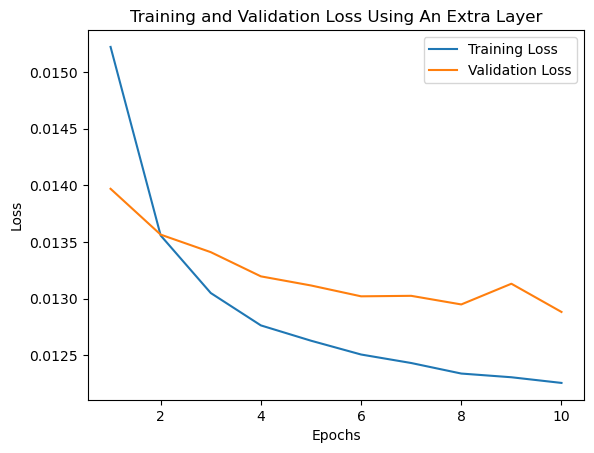

In [71]:
history_dict_add_dropout= history_add_dropou.history
train_acc_add_dropout = history_dict_add_dropout['loss']
val_acc_add_dropout = history_dict_add_dropout['val_loss']
epochs_add_dropout = range(1, len(history_dict_add_dropout['loss'])+1)
plt.plot(epochs_add_dropout, train_acc_add_dropout,label='Training Loss')
plt.plot(epochs_add_dropout, val_acc_add_dropout,label='Validation Loss')
plt.title('Training and Validation Loss Using An Extra Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [68]:
print_test_metrics(emb_model)

Model: "model_12"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_45 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                           

In [69]:
print_test_metrics(model_add_dropout)

Model: "model_13"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_48 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                           

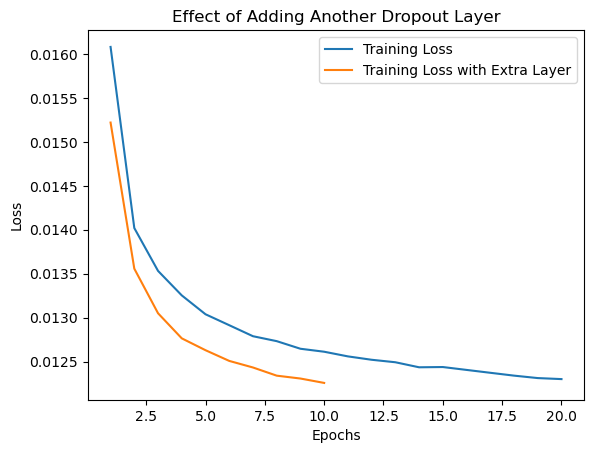

In [75]:

history_dict_emb = emb_history.history
train_acc_emb = history_dict_emb['loss']
val_acc_emb = history_dict_emb['val_loss']
epochs_emb = range(1, len(history_dict_emb['loss'])+1)

plt.plot(epochs_emb, train_acc_emb,label='Training Loss')
plt.plot(epochs_add_dropout, train_acc_add_dropout,label='Training Loss with Extra Layer')
plt.title('Effect of Adding Another Dropout Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

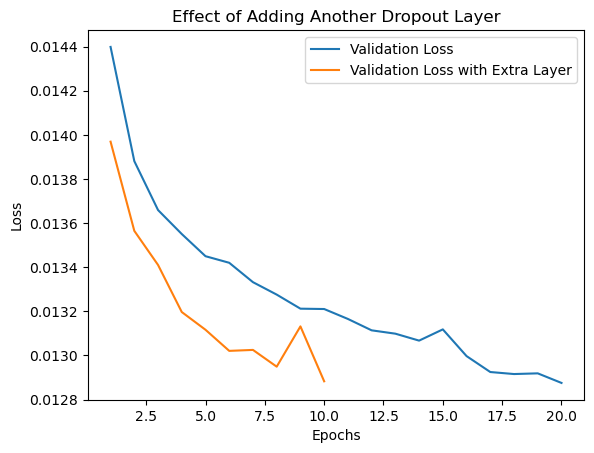

In [77]:
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss')
plt.plot(epochs_add_dropout, val_acc_add_dropout,label='Validation Loss with Extra Layer')

plt.title('Effect of Adding Another Dropout Layer')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [79]:
dropouts = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

epochs_dr = range(1, len(dropouts)+1)
train_accs_dr = []
val_accs_dr = []

for drop in dropouts:
    dr_model, dr_history = train_embedding_model(dropout=drop)
    train_accs_dr.append(dr_history.history['loss'])
    val_accs_dr.append(dr_history.history['val_loss'])

Model: "model_14"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_51 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                           

                                                                                                  
 dense_44 (Dense)               (None, 400)          20800       ['concatenate_18[0][0]']         
                                                                                                  
 dropout_24 (Dropout)           (None, 400)          0           ['dense_44[0][0]']               
                                                                                                  
 dense_45 (Dense)               (None, 40)           16040       ['dropout_24[0][0]']             
                                                                                                  
 dropout_25 (Dropout)           (None, 40)           0           ['dense_45[0][0]']               
                                                                                                  
 dense_46 (Dense)               (None, 1)            41          ['dropout_25[0][0]']             
          

Model: "model_17"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_60 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                           

                                                                                                  
 dense_53 (Dense)               (None, 400)          20800       ['concatenate_21[0][0]']         
                                                                                                  
 dropout_30 (Dropout)           (None, 400)          0           ['dense_53[0][0]']               
                                                                                                  
 dense_54 (Dense)               (None, 40)           16040       ['dropout_30[0][0]']             
                                                                                                  
 dropout_31 (Dropout)           (None, 40)           0           ['dense_54[0][0]']               
                                                                                                  
 dense_55 (Dense)               (None, 1)            41          ['dropout_31[0][0]']             
          

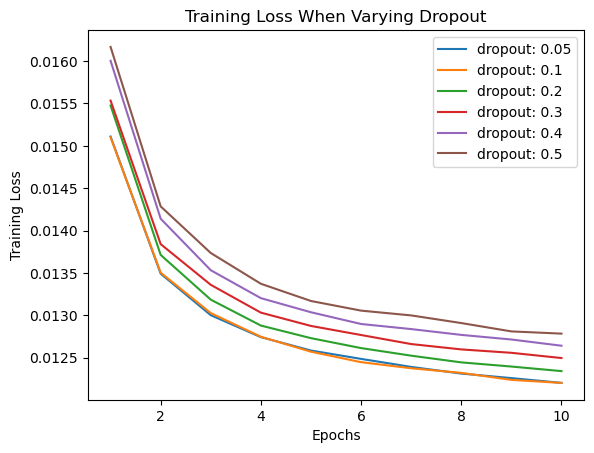

In [82]:
for i in range(len(dropouts)):
    plt.plot(range(1, 11), train_accs_dr[i],label='dropout: '+ str(dropouts[i]))
plt.title('Training Loss When Varying Dropout')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

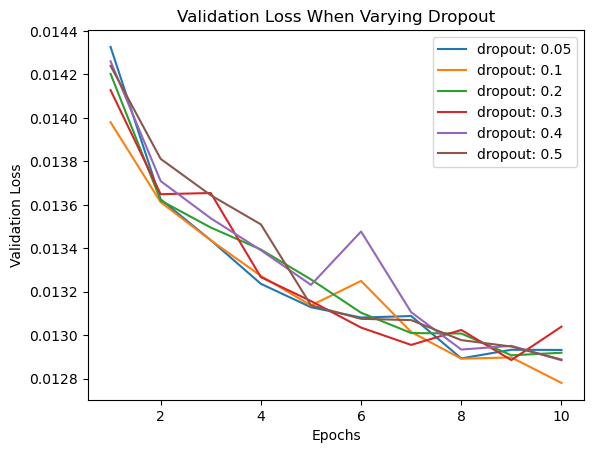

In [83]:
for i in range(len(dropouts)):
    plt.plot(range(1, 11), val_accs_dr[i],label='dropout: '+ str(dropouts[i]))
plt.title('Validation Loss When Varying Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()

In [110]:
emb_model_2, emb_history_2 = train_embedding_model()

Model: "model_26"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_87 (Embedding)       (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                           

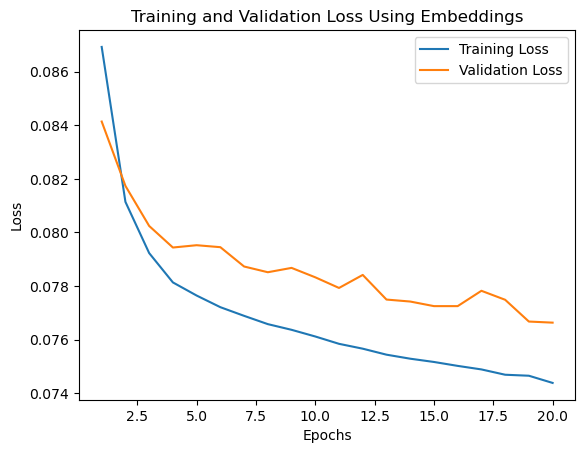

In [111]:
history_dict_emb = emb_history_2.history
train_acc_emb = history_dict_emb['loss']
val_acc_emb = history_dict_emb['val_loss']
epochs_emb = range(1, len(history_dict_emb['loss'])+1)
plt.plot(epochs_emb, train_acc_emb,label='Training Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss')
plt.title('Training and Validation Loss Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

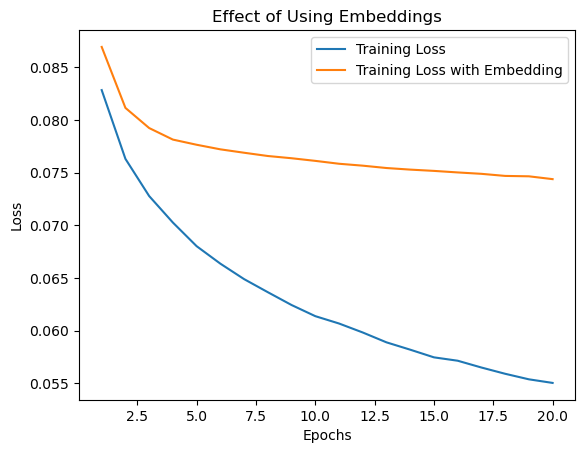

In [112]:
plt.plot(epochs, train_acc,label='Training Loss')
plt.plot(epochs_emb, train_acc_emb,label='Training Loss with Embedding')
plt.title('Effect of Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

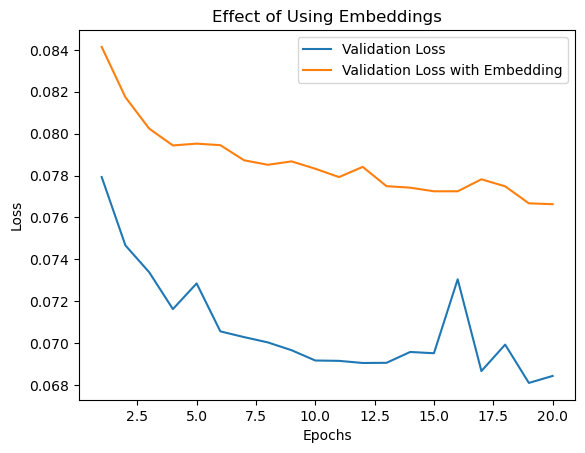

In [113]:
plt.plot(epochs, val_acc,label='Validation Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss with Embedding')
plt.title('Effect of Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [26]:
emb_model, emb_history = train_embedding_model()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding (Embedding)          (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                              

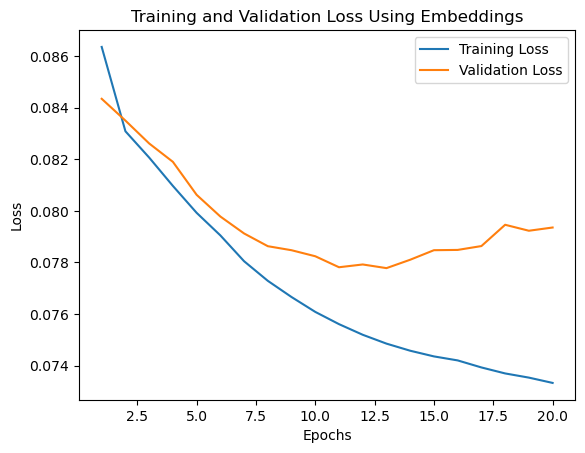

In [28]:
import matplotlib.pyplot as plt

history_dict_emb = emb_history.history
train_acc_emb = history_dict_emb['loss']
val_acc_emb = history_dict_emb['val_loss']
epochs_emb = range(1, len(history_dict_emb['loss'])+1)
plt.plot(epochs_emb, train_acc_emb,label='Training Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss')
plt.title('Training and Validation Loss Using Embeddings')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [43]:
model = tf.keras.models.Sequential([
  tf.keras.layers.Dense(400, input_shape=(970,), activation='relu'),
  tf.keras.layers.Dropout(.2),
  tf.keras.layers.Dense(40, activation='relu'),
  tf.keras.layers.Dropout(.1),
  tf.keras.layers.Dense(1)
])
 
model.summary()
model.compile(
    optimizer=keras.optimizers.RMSprop(learning_rate=.001),
    loss='mean_absolute_error',
    metrics=['mean_absolute_error', 'mean_squared_error'])
 
# Tensorboard
logdir = os.path.join("logs", datetime.datetime.now().strftime("%Y%m%d-%H%M%S"))
tensorboard_callback = tf.keras.callbacks.TensorBoard(logdir, histogram_freq=1)
 
    
np.nan_to_num(X, posinf=np.finfo(np.float16).max, neginf=np.finfo(np.float16).min, copy=False)
np.nan_to_num(Y, posinf=np.finfo(np.float16).max, neginf=np.finfo(np.float16).min, copy=False)

X_scaled = scale_X(X)
Y_scaled = scale_Y(Y)


X_train, X_test, Y_train, Y_test = train_test_split(X_scaled, Y_scaled, test_size=0.33, shuffle=True)
 
history = model.fit(X_train, Y_train, batch_size=32, epochs=20, validation_split=0.2, callbacks=[tensorboard_callback])

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_24 (Dense)            (None, 400)               388400    
                                                                 
 dropout_16 (Dropout)        (None, 400)               0         
                                                                 
 dense_25 (Dense)            (None, 40)                16040     
                                                                 
 dropout_17 (Dropout)        (None, 40)                0         
                                                                 
 dense_26 (Dense)            (None, 1)                 41        
                                                                 
Total params: 404,481
Trainable params: 404,481
Non-trainable params: 0
_________________________________________________________________
Epoch 1/20
23838/23838 [========================

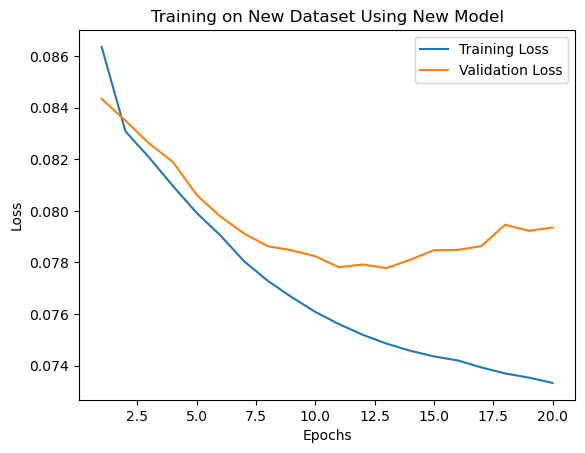

In [61]:
history_dict_emb = emb_history.history
train_acc_emb = history_dict_emb['loss']
val_acc_emb = history_dict_emb['val_loss']
epochs_emb = range(1, len(history_dict_emb['loss'])+1)
plt.plot(epochs_emb, train_acc_emb,label='Training Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss')
plt.title('Training on New Dataset Using New Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

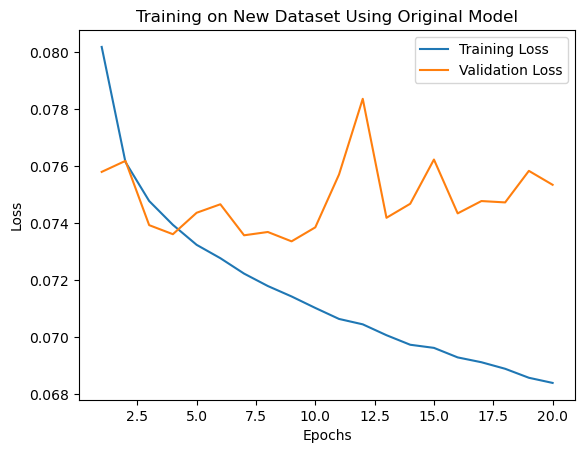

In [60]:
history_dict = history.history
train_acc = history_dict['loss']
val_acc = history_dict['val_loss']
epochs = range(1, len(history_dict['loss'])+1)
plt.plot(epochs, train_acc,label='Training Loss')
plt.plot(epochs, val_acc,label='Validation Loss')
plt.title('Training on New Dataset Using Original Model')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

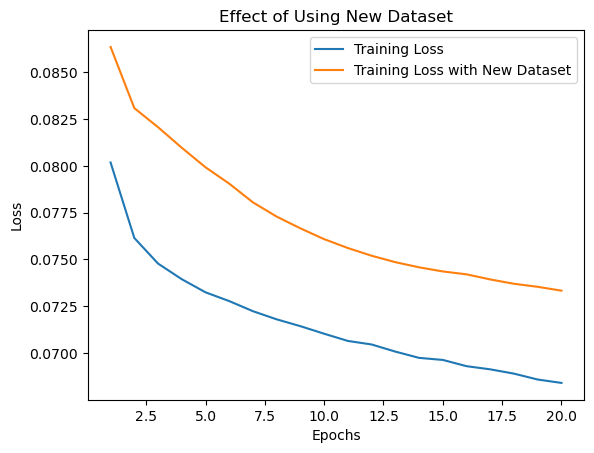

In [53]:
plt.plot(epochs, train_acc,label='Training Loss')
plt.plot(epochs_emb, train_acc_emb,label='Training Loss with New Dataset')
plt.title('Effect of Using New Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

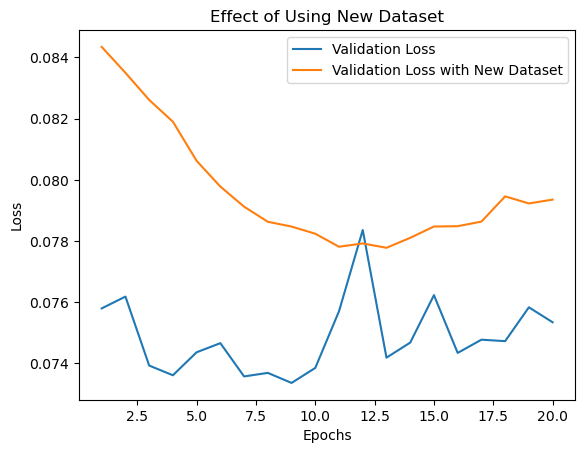

In [55]:
plt.plot(epochs, val_acc,label='Validation Loss')
plt.plot(epochs_emb, val_acc_emb,label='Validation Loss with New Dataset')
plt.title('Effect of Using New Dataset')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [50]:
dropouts = [0.05, 0.1, 0.2, 0.3, 0.4, 0.5]

epochs_dr = range(1, len(dropouts)+1)
train_accs_dr = []
val_accs_dr = []

for drop in dropouts:
    dr_model, dr_history = train_embedding_model(dropout=drop)
    train_accs_dr.append(dr_history.history['loss'])
    val_accs_dr.append(dr_history.history['val_loss'])

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 cards_input (InputLayer)       [(None, 45)]         0           []                               
                                                                                                  
 relics_input (InputLayer)      [(None, 25)]         0           []                               
                                                                                                  
 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_3 (Embedding)        (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                            

 encounter_input (InputLayer)   [(None, 1)]          0           []                               
                                                                                                  
 embedding_6 (Embedding)        (None, 45, 26)       18590       ['cards_input[0][0]']            
                                                                                                  
 embedding_7 (Embedding)        (None, 25, 13)       2340        ['relics_input[0][0]']           
                                                                                                  
 embedding_8 (Embedding)        (None, 1, 8)         584         ['encounter_input[0][0]']        
                                                                                                  
 lambda_6 (Lambda)              (None, 26)           0           ['embedding_6[0][0]']            
                                                                                                  
 lambda_7 

                                                                                                  
 lambda_9 (Lambda)              (None, 26)           0           ['embedding_9[0][0]']            
                                                                                                  
 lambda_10 (Lambda)             (None, 13)           0           ['embedding_10[0][0]']           
                                                                                                  
 lambda_11 (Lambda)             (None, 8)            0           ['embedding_11[0][0]']           
                                                                                                  
 num_and_bool_input (InputLayer  [(None, 4)]         0           []                               
 )                                                                                                
                                                                                                  
 concatena

 num_and_bool_input (InputLayer  [(None, 4)]         0           []                               
 )                                                                                                
                                                                                                  
 concatenate_4 (Concatenate)    (None, 51)           0           ['lambda_12[0][0]',              
                                                                  'lambda_13[0][0]',              
                                                                  'lambda_14[0][0]',              
                                                                  'num_and_bool_input[0][0]']     
                                                                                                  
 dense_36 (Dense)               (None, 400)          20800       ['concatenate_4[0][0]']          
                                                                                                  
 dropout_2

                                                                                                  
 dense_39 (Dense)               (None, 400)          20800       ['concatenate_5[0][0]']          
                                                                                                  
 dropout_26 (Dropout)           (None, 400)          0           ['dense_39[0][0]']               
                                                                                                  
 dense_40 (Dense)               (None, 40)           16040       ['dropout_26[0][0]']             
                                                                                                  
 dropout_27 (Dropout)           (None, 40)           0           ['dense_40[0][0]']               
                                                                                                  
 dense_41 (Dense)               (None, 1)            41          ['dropout_27[0][0]']             
          

 dropout_29 (Dropout)           (None, 40)           0           ['dense_43[0][0]']               
                                                                                                  
 dense_44 (Dense)               (None, 1)            41          ['dropout_29[0][0]']             
                                                                                                  
Total params: 58,395
Trainable params: 58,395
Non-trainable params: 0
__________________________________________________________________________________________________
Epoch 1/20
23838/23838 [==============================] - 129s 5ms/step - loss: 0.0893 - mae: 0.0893 - mse: 0.0175 - val_loss: 0.0849 - val_mae: 0.0849 - val_mse: 0.0158
Epoch 2/20
23838/23838 [==============================] - 127s 5ms/step - loss: 0.0860 - mae: 0.0860 - mse: 0.0164 - val_loss: 0.0840 - val_mae: 0.0840 - val_mse: 0.0161
Epoch 3/20
23838/23838 [==============================] - 130s 5ms/step - loss: 0.0852 - mae: 0

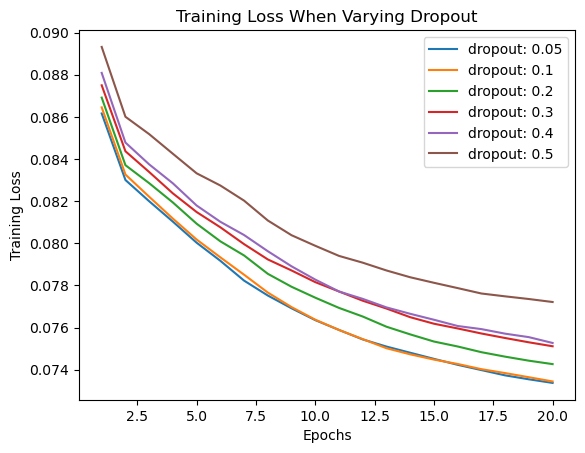

In [56]:
for i in range(len(dropouts)):
    plt.plot(range(1, 21), train_accs_dr[i],label='dropout: '+ str(dropouts[i]))
plt.title('Training Loss When Varying Dropout')
plt.xlabel('Epochs')
plt.ylabel('Training Loss')
plt.legend()
plt.show()

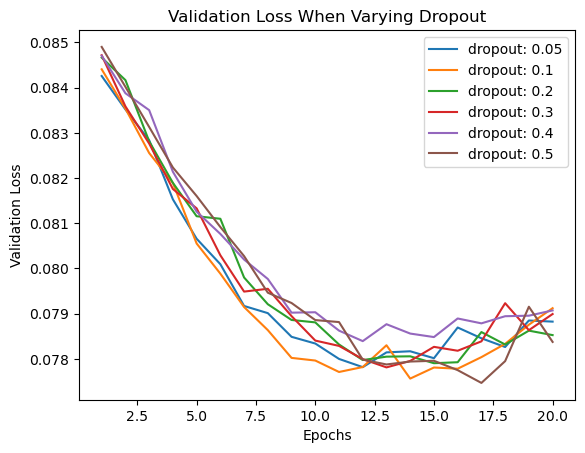

In [57]:
for i in range(len(dropouts)):
    plt.plot(range(1, 21), val_accs_dr[i],label='dropout: '+ str(dropouts[i]))
plt.title('Validation Loss When Varying Dropout')
plt.xlabel('Epochs')
plt.ylabel('Validation Loss')
plt.legend()
plt.show()